# Aleket Faster R-CNN training notebook

In [ ]:
%pip install pillow
%pip install numpy<2.0
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124
%pip install matplotlib
%pip install gdown
%pip install tqdm
from IPython.display import clear_output
clear_output(wait=False)

print("ALL DEPENDENCIES INSTALLED")


In [1]:
# IMPORTS

# Standard Library
import random
import os

# Third-Party Libraries
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

# Torch
import torch

# Utils
from aleket_dataset import AleketDataset, download_dataset
from utils import split_dataset, get_model, load_checkpoint
from training_and_evaluation import train
from dataset_statisics import visualize_samples, count_analyze
from run_params import RunParams, parse_params
from predictor import Predictor
from metrics import Evaluator, VALIDATION_METRICS

In [2]:
# Helper functions
def augment_example(ds):
    examples = visualize_samples(ds, image_ids_to_visualize=range(4))
    fig=plt.figure(figsize=(40, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(examples[i-1])
    plt.show()

def draw_heat_map(name: str, values: np.ndarray, ax: Axes, x_ticks: np.ndarray, y_ticks: np.ndarray):

    masked_results = np.ma.masked_where(values == -1, values)
    ax.imshow(masked_results, cmap='viridis', vmin=0, interpolation='nearest')

    X = len(x_ticks)
    Y = len(y_ticks)

    ax.set_title(name)
    ax.set_xlabel('Score Threshold')
    ax.set_ylabel('NMS Threshold')
    ax.set_xticks(np.arange(X))
    ax.set_yticks(np.arange(Y))
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)
    max_val = values.max()
    
    for i in range(Y):
        for j in range(X):
            value = values[i, j]
            color = 'black' if value > max_val/2 else 'white'
            text = ax.text(j, i, f'{value:.3f}', ha="center", va="center", color=color)

In [3]:
# Device Selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Random Seed for Reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
np_generator = np.random.default_rng(SEED)

# Dataset split
DATASET_FRACTION = 1
VALIDATION_FRACTION = 0.2
dataset = AleketDataset(download_dataset("dataset_patched", ""))
full_dataset = AleketDataset(download_dataset("dataset_full_images", ""))
train_set, val_set = split_dataset(dataset, DATASET_FRACTION, VALIDATION_FRACTION, np_generator)

# Model
model = get_model(device)

print(f"Using model: {model._get_name()}")

Using device: cuda
Dataset loaded from dataset_patched
Dataset loaded from dataset_full_images
Using model: FasterRCNN


In [4]:
RUN_NAME = "run_local"

params = RunParams(
    run_name=RUN_NAME,
    batch_size=16,
    dataloader_workers=16, 
    total_epochs=10,
    augmentation={
        "horizontal_flip": {
            "p": 0.5
        },
        "vertical_flip": {
            "p": 0.5
        },
        "perspective": {
            "distortion_scale": 0.2,
            "p": 0.5
        },
        "rotation": {
            "degrees": 15,
            "expand": True
        },
        "color_jitter": {
            "brightness": 0.2,
            "contrast": 0.1,
            "saturation": 0.05
        }
    },
    optimizer={
        "lr": 0.001,
        "momentum": 0.9,
        "weight_decay": 0.0001
    },
    lr_scheduler={
        "factor": 0.5,
        "patience": 10,
        "min_lr": 0.0001
    },
    validation_set=val_set,
    train_set=train_set
    )


print(f"Train parameters for '{RUN_NAME}'")

Train parameters for 'run_local'


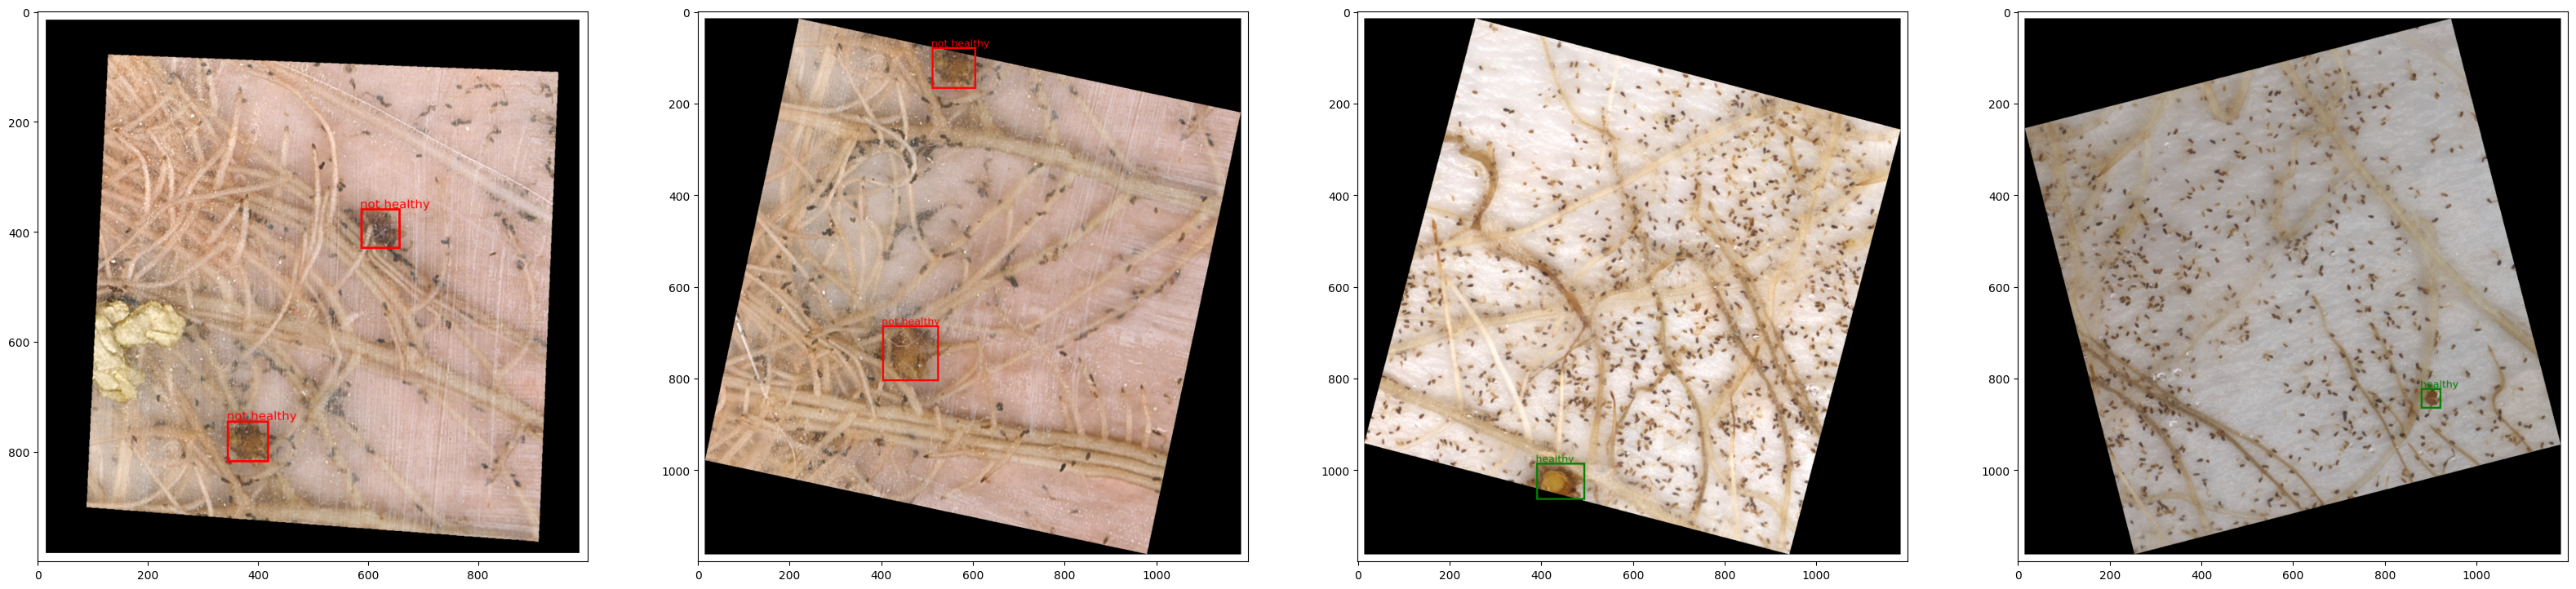

In [5]:
parsed_params = parse_params(params, model, dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

count_analyze(dataset, save_folder="patched_dataset_statistics")
count_analyze(dataset, indices=train_dataloader.dataset.indices, save_folder="patched_train_dataset_statistics")
count_analyze(dataset, indices=val_dataloader.dataset.indices, save_folder="patched_val_dataset_statistics")

dataset.augmentation = augmentation
augment_example(train_dataloader.dataset)

In [ ]:
train(model, dataset, params, device, checkpoints=True, verbose=False)

In [ ]:
params.load(os.path.join()) # override parameters
train(model, dataset, params, device, checkpoints=True, resume=True, verbose=False)

In [ ]:
RUN_NAME_TO_TEST = "run_local"

res_dir = os.path.join("results", RUN_NAME_TO_TEST)
params_path = os.path.join(res_dir, "params.json")
checkpoint_path = os.path.join(res_dir,"checkpoints", "last.pth")

model = get_model(device)
params = RunParams()
params.load(params_path)

val_set = params.validation_set


val_indices = [int(full_image_name) for full_image_name in val_set.keys()]
model = load_checkpoint(model, checkpoint_path)[0]

predictor = Predictor(
    model,
    device,
    200,
)

In [ ]:
nms_thrs = np.round(np.flip(np.arange(0.3, 0.7 + 1e-3, 0.1)),2)
score_thrs = np.round(np.arange(0.01, 0.3 + 1e-4, 0.01),2)

N = len(nms_thrs)
S = len(score_thrs)

eval = Evaluator(full_dataset, val_indices,)

results_ap  = np.full((N,S), -1.0)
results_aad = np.full((N,S), -1.0)
results_acd = np.full((N,S), -1.0)

for i, n in enumerate(nms_thrs):
    for j, s in tqdm(enumerate(score_thrs), total=S):
        try:
            stats = predictor.eval_dataset(full_dataset, val_indices, n, s, eval)
            results_ap[i, j] = stats[VALIDATION_METRICS[0]]
            results_acd[i, j] = stats[VALIDATION_METRICS[-2]]
            results_aad[i, j] = stats[VALIDATION_METRICS[-1]]
        except Exception as e:
            break

In [ ]:
np.savetxt(os.path.join(res_dir,"ap_analysis.csv"), results_ap, delimiter=',', fmt='%.4f')
np.savetxt(os.path.join(res_dir,"aad_analysis.csv"), results_aad, delimiter=',', fmt='%.4f')
np.savetxt(os.path.join(res_dir,"acd_analysis.csv"), results_acd, delimiter=',', fmt='%.4f')

fig, axes = plt.subplots(3, 1, figsize=(60, 10))

draw_heat_map("AP",  results_ap, axes[0], score_thrs, nms_thrs)
draw_heat_map("AAD", results_aad, axes[1],score_thrs, nms_thrs)
draw_heat_map("ACD", results_acd, axes[2],score_thrs, nms_thrs)

plt.tight_layout()
plt.show()